## 2.1 Import Python Libraries

In [1]:
import boto3, cv2, time, numpy as np, matplotlib.pyplot as plt, random, os, concurrent.futures
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 2.2 Check if Endpoint creation is successful and create the predictor

In [2]:
sm_client = boto3.client(service_name="sagemaker")

# Restore the endpoint name stored in the 1_DeployEndpoint.ipynb notebook
# %store -r ENDPOINT_NAME
ENDPOINT_NAME = 'yolov8-pytorch-2024-03-11-22-53-50-671605'
print(f'Endpoint Name: {ENDPOINT_NAME}')

endpoint_created = False
while True:
    response = sm_client.list_endpoints()
    for ep in response['Endpoints']:
        print(f"Endpoint Status = {ep['EndpointStatus']}")
        if ep['EndpointName']==ENDPOINT_NAME and ep['EndpointStatus']=='InService':
            endpoint_created = True
            break
    if endpoint_created:
        break
    time.sleep(5)

Endpoint Name: yolov8-pytorch-2024-03-11-22-53-50-671605
Endpoint Status = InService


In [3]:
predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME,
                             deserializer=JSONDeserializer())

In [4]:
import psutil
import numpy as np
import cv2
import boto3
import time
import random
import threading
from tqdm import tqdm
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor

In [5]:
# Function to record CPU and memory usage over time
def record_usage(usage_stats):
    while keep_recording:
        cpu_percent = psutil.cpu_percent()
        memory_info = psutil.virtual_memory()
        usage_stats.append((time.time(), cpu_percent, memory_info.percent))
        time.sleep(1) 

# Function to start the monitoring thread
def start_monitoring():
    global keep_recording
    keep_recording = True
    usage_stats = []
    monitor_thread = threading.Thread(target=record_usage, args=(usage_stats,))
    monitor_thread.start()
    return usage_stats, monitor_thread

# Function to stop the monitoring thread
def stop_monitoring(monitor_thread):
    global keep_recording
    keep_recording = False
    monitor_thread.join()

In [6]:
def process_image(payload):
    result = predictor.predict(payload)
    return result

In [7]:
random.seed(50)

## 2.3 Run Inference and Generate output results

In [8]:
# Setup S3 client and variables
s3_client = boto3.client('s3')
bucket_name = 'jmayank'
prefix = 'data/'
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
global_image_paths = [x['Key'] for x in response['Contents']][1:]
num_iters = 5


# Main profiling loop
for num_samples in [1, 5, 25, 50]:
    times = []
    all_cpu_usages = []
    all_memory_usages = []

    for _ in tqdm(range(num_iters)):
        # Start monitoring
        usage_stats, monitor_thread = start_monitoring()

        image_paths = random.sample(global_image_paths, num_samples)
        payload_list = []
        # Your image processing logic here
        for file_name in image_paths:
            # Download the image from S3
            file_obj = s3_client.get_object(Bucket=bucket_name, Key=file_name)
            file_content = file_obj['Body'].read()

            # Convert bytes to numpy array
            nparr = np.frombuffer(file_content, np.uint8)
            orig_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            image_height, image_width, _ = orig_image.shape
            model_height, model_width = 300, 300
            x_ratio = image_width/model_width
            y_ratio = image_height/model_height

            resized_image = cv2.resize(orig_image, (model_height, model_width))
            payload = cv2.imencode('.jpg', resized_image)[1].tobytes()
            payload_list.append(payload)

        total_infer_time_start = time.time()

        with Pool(processes=10) as pool:
            results = pool.map(process_image, payload_list)


        total_infer_time_end = time.time()
        times.append(total_infer_time_end - total_infer_time_start)

        for result in results:
            if 'boxes' in result:
                for idx,(x1,y1,x2,y2,conf,lbl) in enumerate(result['boxes']):
                    # Draw Bounding Boxes
                    x1, x2 = int(x_ratio*x1), int(x_ratio*x2)
                    y1, y2 = int(y_ratio*y1), int(y_ratio*y2)
                    color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
                    cv2.rectangle(orig_image, (x1,y1), (x2,y2), color, 4)
                    cv2.putText(orig_image, f"Class: {int(lbl)}", (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
                    cv2.putText(orig_image, f"Conf: {int(conf*100)}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
                    if 'masks' in result:
                        # Draw Masks
                        mask = cv2.resize(np.asarray(result['masks'][idx]), dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                        for c in range(3):
                            orig_image[:,:,c] = np.where(mask>0.5, orig_image[:,:,c]*(0.5)+0.5*color[c], orig_image[:,:,c])

            if 'probs' in result:
                # Find Class
                lbl = result['probs'].index(max(result['probs']))
                color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
                cv2.putText(orig_image, f"Class: {int(lbl)}", (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

            if 'keypoints' in result:
                # Define the colors for the keypoints and lines
                keypoint_color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
                line_color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))

                # Define the keypoints and the lines to draw
                # keypoints = keypoints_array[:, :, :2]  # Ignore the visibility values
                lines = [
                    (0, 1), (0, 2), (1, 3), (2, 4),  # Head
                    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),  # Torso
                    (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)  # Legs
                ]

                # Draw the keypoints and the lines on the image
                for keypoints_instance in result['keypoints']:
                    # Draw the keypoints
                    for keypoint in keypoints_instance:
                        if keypoint[2] == 0:  # If the keypoint is not visible, skip it
                            continue
                        cv2.circle(orig_image, (int(x_ratio*keypoint[:2][0]),int(y_ratio*keypoint[:2][1])), radius=5, color=keypoint_color, thickness=-1)

                    # Draw the lines
                    for line in lines:
                        start_keypoint = keypoints_instance[line[0]]
                        end_keypoint = keypoints_instance[line[1]]
                        if start_keypoint[2] == 0 or end_keypoint[2] == 0:  # If any of the keypoints is not visible, skip the line
                            continue
                        cv2.line(orig_image, (int(x_ratio*start_keypoint[:2][0]),int(y_ratio*start_keypoint[:2][1])),(int(x_ratio*end_keypoint[:2][0]),int(y_ratio*end_keypoint[:2][1])), color=line_color, thickness=2)


        #Stop monitoring
        stop_monitoring(monitor_thread)

        # Extract CPU and memory usage over time
        timestamps = [record[0] for record in usage_stats]
        cpu_usages = [record[1] for record in usage_stats]
        memory_usages = [record[2] for record in usage_stats]
        all_cpu_usages.append(cpu_usages)
        all_memory_usages.append(memory_usages)

    # Output the profiling results for this batch size
    print(f'Num samples: {num_samples}, mean time = {np.mean(times)}, std dev = {np.std(times)}')

100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Num samples: 1, mean time = 0.8339049816131592, std dev = 0.026629643832635358


100%|██████████| 5/5 [00:50<00:00, 10.02s/it]


Num samples: 5, mean time = 9.281747102737427, std dev = 2.728826773977681


100%|██████████| 5/5 [04:32<00:00, 54.48s/it]


Num samples: 25, mean time = 52.570879220962524, std dev = 0.23766942121290488


100%|██████████| 5/5 [08:57<00:00, 107.54s/it]

Num samples: 50, mean time = 104.666015291214, std dev = 0.5098171206968601


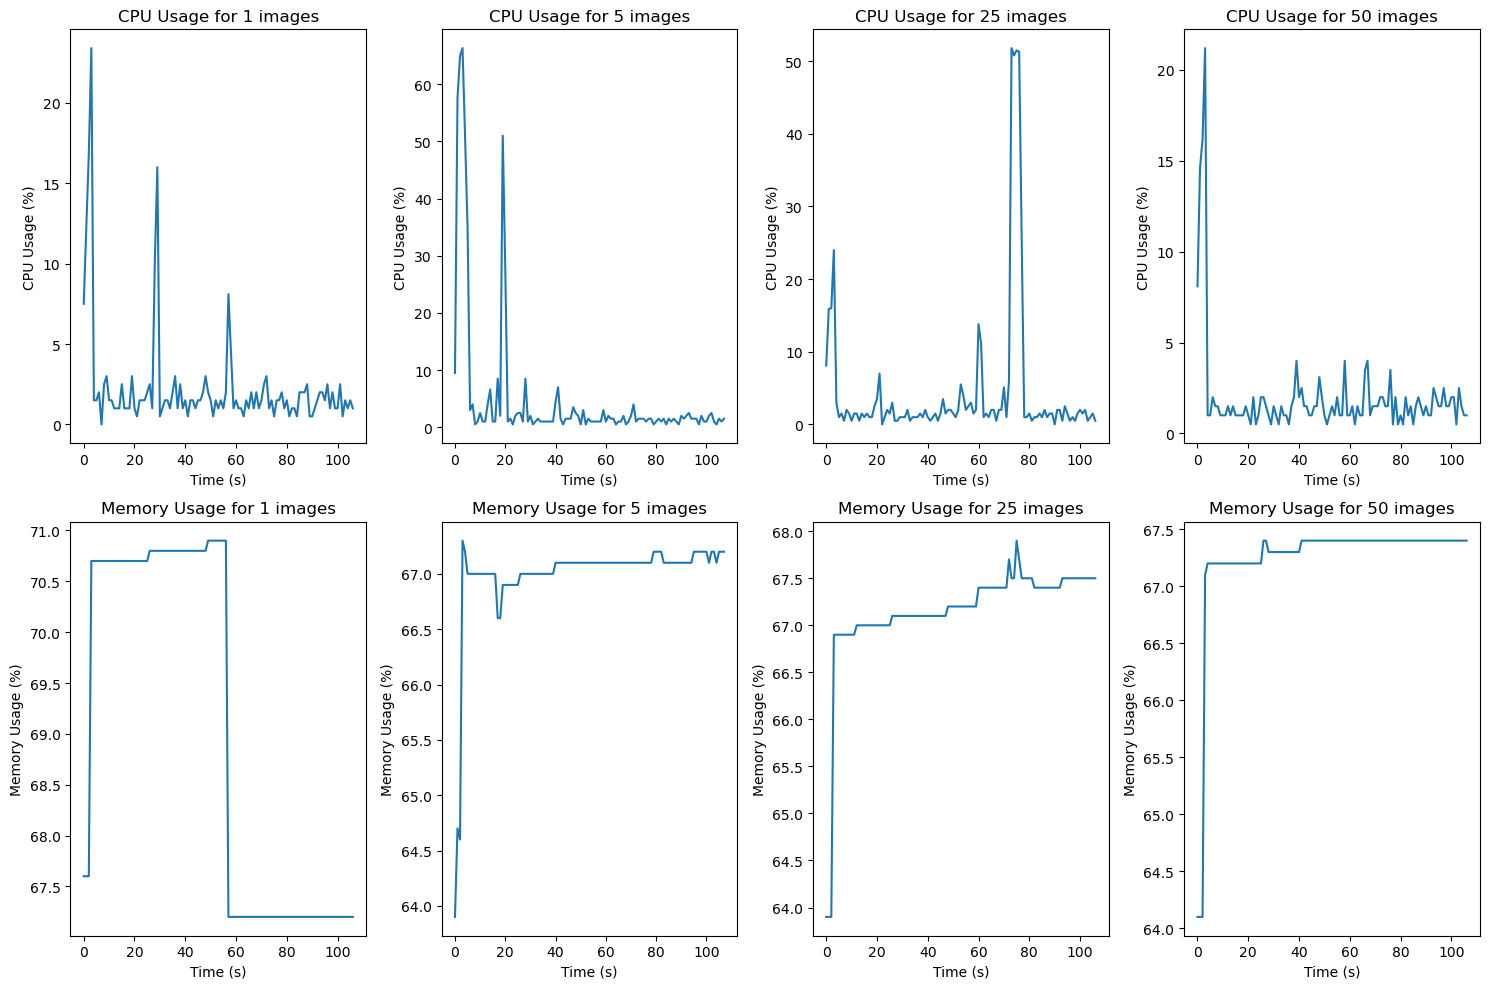

In [9]:
import matplotlib.pyplot as plt

num_samples_in_exp = [1, 5, 25, 50]

# Function to plot CPU and Memory usage
def plot_usages(cpu_usages, memory_usages, num_samples):
    # Assuming each entry in cpu_usages and memory_usages corresponds to a different trial
    fig, axs = plt.subplots(2, len(num_samples_in_exp), figsize=(15, 10))
    for i in range(len(num_samples_in_exp)):
        # CPU Usage plots
        axs[0, i].plot(cpu_usages[i])
        axs[0, i].set_title(f'CPU Usage for {num_samples[i]} images')
        axs[0, i].set_xlabel('Time (s)')
        axs[0, i].set_ylabel('CPU Usage (%)')

        # Memory Usage plots
        axs[1, i].plot(memory_usages[i])
        axs[1, i].set_title(f'Memory Usage for {num_samples[i]} images')
        axs[1, i].set_xlabel('Time (s)')
        axs[1, i].set_ylabel('Memory Usage (%)')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the plotting function with your data
plot_usages(all_cpu_usages, all_memory_usages, num_samples_in_exp)


## 2.4 Cleanup by removing Endpoint, Endpoint Config and Model

In [10]:
response = sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
print(response)
endpoint_config_name = response['EndpointConfigName']

# Delete Endpoint
sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)

# Delete Endpoint Configuration
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# Delete Model
for prod_var in response['ProductionVariants']:
    model_name = prod_var['ModelName']
    sm_client.delete_model(ModelName=model_name)     

{'EndpointConfigName': 'yolov8-pytorch-2024-03-11-22-53-50-671605', 'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:017853670777:endpoint-config/yolov8-pytorch-2024-03-11-22-53-50-671605', 'ProductionVariants': [{'VariantName': 'AllTraffic', 'ModelName': 'pytorch-inference-2024-03-11-22-53-57-406', 'InitialInstanceCount': 1, 'InstanceType': 'ml.c5.4xlarge', 'InitialVariantWeight': 1.0}], 'CreationTime': datetime.datetime(2024, 3, 11, 22, 53, 58, 229000, tzinfo=tzlocal()), 'EnableNetworkIsolation': False, 'ResponseMetadata': {'RequestId': '9813804b-89f3-4b54-8480-e0a8a39c6112', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '9813804b-89f3-4b54-8480-e0a8a39c6112', 'content-type': 'application/x-amz-json-1.1', 'content-length': '441', 'date': 'Mon, 11 Mar 2024 23:15:12 GMT'}, 'RetryAttempts': 0}}
